<a href="https://colab.research.google.com/github/felipe-parodi/DL4DataScience/blob/main/Week2_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 2 Homework: Design a deep network for linear regression on the QSAR Fish Toxicity dataset.

In [ ]:
import numpy as np
import pandas as pd
import random, time
import matplotlib.pylab as plt
%matplotlib inline 
import matplotlib as mpl
from tqdm.notebook import tqdm, trange

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00504/qsar_fish_toxicity.csv'

headers = ['CIC0', 'SM1_Dz(Z)', 'GATS1i', 'NdsCH', 'NdssC', 'MLogP', 'LC50']

df1 = pd.read_csv(url, names = headers, header=None, delimiter=";")

X = np.array(df1)[:,:-1]
y = np.array(df1)[:,-1].reshape(-1,1)

print(f'Data: \n{df1}')

print(f'\ninput shape of X: {X.shape}, ' 
      f'targets shape of y: {y.shape}')

Data: 
      CIC0  SM1_Dz(Z)  GATS1i  NdsCH  NdssC  MLogP   LC50
0    3.260      0.829   1.676      0      1  1.453  3.770
1    2.189      0.580   0.863      0      0  1.348  3.115
2    2.125      0.638   0.831      0      0  1.348  3.531
3    3.027      0.331   1.472      1      0  1.807  3.510
4    2.094      0.827   0.860      0      0  1.886  5.390
..     ...        ...     ...    ...    ...    ...    ...
903  2.801      0.728   2.226      0      2  0.736  3.109
904  3.652      0.872   0.867      2      3  3.983  4.040
905  3.763      0.916   0.878      0      6  2.918  4.818
906  2.831      1.393   1.077      0      1  0.906  5.317
907  4.057      1.032   1.183      1      3  4.754  8.201

[908 rows x 7 columns]

input shape of X: (908, 5), targets shape of y: (908, 1)
[[3.26  0.829 1.676 0.    1.   ]
 [2.189 0.58  0.863 0.    0.   ]
 [2.125 0.638 0.831 0.    0.   ]
 ...
 [3.763 0.916 0.878 0.    6.   ]
 [2.831 1.393 1.077 0.    1.   ]
 [4.057 1.032 1.183 1.    3.   ]]


Original dimensions:  (908, 6)
Reduced dimension:  (908, 2)


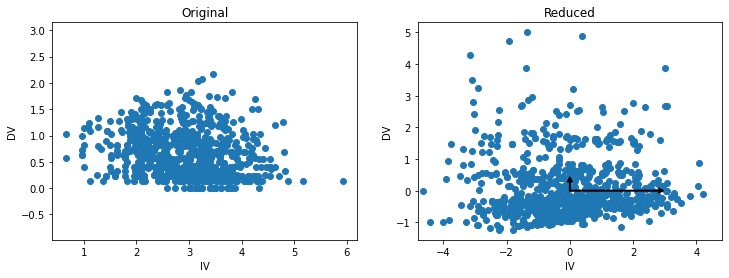

In [ ]:
#@markdown ## 1. Decompose and visualize data (2 dims)
# 1. Decompose and visualize data
pca = PCA(2) # project from 6 to 2 dimensions
pca.fit(X)
Z = pca.transform(X)
def arrow(v1, v2, ax):
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate("", v2, v1, arrowprops=arrowprops)

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].axis('equal')
axes[0].scatter(X[:,0], X[:,1])
axes[1].axis('equal')
axes[1].set_xlim(-3,3)
axes[1].scatter(Z[:,0], Z[:,1])
# for l, v in zip(pca.explained_variance_, pca.components_):
#     arrow([0,0], v*l*3, axes[0])
for l, v in zip([1.0,0.16], [np.array([1.0,0.0]),np.array([0.0,1.0])]):
    arrow([0,0], v*l*3, axes[1])
axes[0].set_title("Original")
axes[0].set_xlabel('IV')
axes[0].set_ylabel('DV')
axes[1].set_title("Reduced")
axes[1].set_xlabel('IV')
axes[1].set_ylabel('DV');

print('Original dimensions: ', X.shape)
print('Reduced dimension: ', Z.shape)


The training loss is: 0.875111997127533
The test loss is: 1.0283515453338623


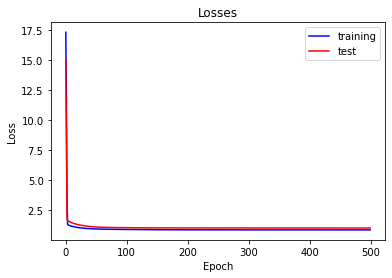

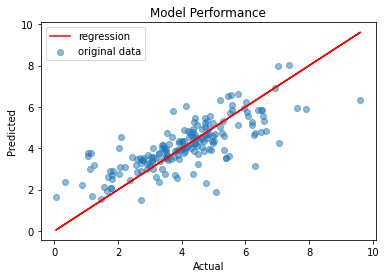

In [ ]:
# 2. Split data
train_size = 0.8
test_size = 0.2
train_X, test_X, train_y, test_y = train_test_split(X, y, 
      train_size=train_size, test_size=test_size, random_state=42)

# Convert numpy array to tensor
X = torch.from_numpy(train_X.astype(np.float32))
y = torch.from_numpy(train_y.astype(np.float32))
x_test = torch.from_numpy(test_X.astype(np.float32))
y_test = torch.from_numpy(test_y.astype(np.float32))

# 3. Build network
input_dim = 6
output_dim = 1
h1, h2, h3 = 20, 15, 10

mynetwork = nn.Sequential(nn.Linear(input_dim, h1),
                      nn.Linear(h1, h2),
                      nn.Linear(h2, h3),
                      nn.Linear(h3, output_dim))


# 4. Set hyperparameters
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(mynetwork.parameters(), lr=learning_rate)

training_losses = []
test_losses = []
num_epochs = 500
epoch_range = trange(num_epochs, desc='loss: ', leave=True)


# 5.1 Training 
for epoch in epoch_range:
  if training_losses:
    epoch_range.set_description("loss: {:.6f}".format(training_losses[-1]))
    epoch_range.refresh()
  time.sleep(0.01)

  # Compute loss, backpropagate, update, zero gradients
  training_loss = criterion(mynetwork(X), y)
  training_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Compile losses
  training_losses.append(training_loss)

  if test_losses:
    epoch_range.set_description("loss: {:.6f}".format(test_losses[-1]))
    epoch_range.refresh()
  time.sleep(0.01)

  # Compute loss, backpropagate, update, zero gradients
  test_loss = criterion(mynetwork(x_test), y_test)
  test_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Compile losses
  test_losses.append(test_loss)

# Print training and testing loss
preds_train = mynetwork(X) # 726x6 x 6x20
preds_test = mynetwork(x_test) # 182x6 x 6x20
training_loss = criterion(preds_train, y)
test_loss = criterion(preds_test, y_test)
print(f'The training loss is: {training_loss}')
print(f'The test loss is: {test_loss}')

# 5.2 Plot training and test loss vs. number of epochs
plt.figure()
plt.plot(training_losses, label='training', color='b')
plt.plot(test_losses, label='test',color= 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.show()

predicted = mynetwork(x_test).detach().numpy()


# 6. Plot model's performance
## doesn't yet plot what i want... i want y=y_hat
plt.figure()
plt.scatter(y_test, preds_test.detach().numpy(), 
            label='original data', alpha=0.5)
plt.plot(y_test, y_test, label='regression', color='red') 
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Performance')
plt.legend()
plt.show()


In [ ]:
# 7. Train the model again by removing a feature
# train_size = 0.8
# test_size = 0.2
# train_X, test_X, train_y, test_y = train_test_split(X, y, 
#       train_size=train_size, test_size=test_size, random_state=42)

# # Convert numpy array to tensor
# X = torch.from_numpy(train_X.astype(np.float32))
# y = torch.from_numpy(train_y.astype(np.float32))
# x_test = torch.from_numpy(test_X.astype(np.float32))
# y_test = torch.from_numpy(test_y.astype(np.float32))


##### STEPS ####
# remove a feature to make X_removed
# split data to make X_train_removed and X_test_removed
# train

# Build network
input_dim = 5 # remove one feature
output_dim = 1
h1, h2, h3 = 20, 15, 10

mynetwork = nn.Sequential(nn.Linear(input_dim, h1),
                      nn.Linear(h1, h2),
                      nn.Linear(h2, h3),
                      nn.Linear(h3, output_dim))


# 4. Set hyperparameters
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(mynetwork.parameters(), lr=learning_rate)

losses = []
predictions = []
num_epochs = 500
epoch_range = trange(num_epochs, desc='loss: ', leave=True)


# Training 
for epoch in epoch_range:
  for i in range(6):
    X 
    if losses:
      epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
      epoch_range.refresh()
    time.sleep(0.01)

    # Compute loss, backpropagate, update, zero gradients
    loss = criterion(mynetwork(X), y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Compile losses
    losses.append(loss)

predicted = mynetwork(x_test).detach().numpy()
predictions.append(predicted)


# 6. Plot model's performance
plt.figure()
plt.scatter(y_test, preds_test.detach().numpy(), 
            label='original data', alpha=0.5)
plt.plot(y_test, y_test, label='regression', color='red') 
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Model Performance')
plt.legend()
plt.show()



## Remove CICO

## Remove SM1_Dz(Z)

## Remove GATS1i

## Remove NdsCH

## Remove NdssC

## Remove MLogP


plt.figure()
 for i, preds in enumerate(predictions):
   plt.subplot(2, 3, i + 1)
   plt.plot(...)  # plot original y vs. y_hat
   plt.plot(...)  # y=y_hat
   plt.legend()